In [1]:
! pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 949 kB/s eta 0:00:01


# Module

In [2]:
#Import Library
import random
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow with Keras.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dropout
tf.compat.v1.disable_eager_execution()

# ART
import art
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

# Dataset

In [3]:
# MNIST 데이터셋 준비

mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()   

# 각 데이터 크기 출력
print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

x_train.shape: (60000, 28, 28)
y_train.shape: (60000,)
x_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


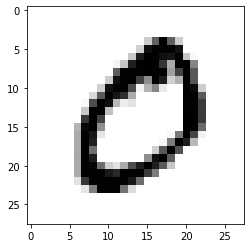

0


In [4]:
# x_train[1] 이미지 출력, y_train 확인
plt.imshow(x_train[1],cmap=plt.cm.binary)
plt.show()

print(y_train[1])

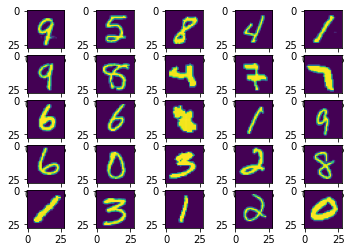

In [5]:
# Visualize random datasets
#Visualize Dataset 
show_images = []
for _ in range(5 * 5):
    show_images.append(x_train[random.randint(0, len(x_train))])

for idx, image in enumerate(show_images):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(image)

# Preprocessing

In [6]:
# Normalization - x
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

x_train_norm = x_train.astype('float32')/255.0
x_test_norm = x_test.astype('float32') / 255.0

print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))
#print(f"x_train.shape: {x_train.shape}")

최소값: 0  최대값: 255
최소값: 0.0  최대값: 1.0


In [7]:
# Normalization - y (One-hot-encoding)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Model

In [8]:
from keras.layers import Input,Conv2D,Dropout, Dense,Flatten,GlobalAveragePooling2D,MaxPool2D
from keras.models import Model

#  tf.keras의 Sequential API를 이용하여 LeNet 모델 생성
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [10]:
# 채널수 맞추기
print("Before Reshape - x_train_norm shape: {}".format(x_train_norm.shape))
print("Before Reshape - x_test_norm shape: {}".format(x_test_norm.shape))

x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 1)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 1)

print("After Reshape - x_train_reshaped shape: {}".format(x_train_reshaped.shape))
print("After Reshape - x_test_reshaped shape: {}".format(x_test_reshaped.shape))


Before Reshape - x_train_norm shape: (60000, 28, 28)
Before Reshape - x_test_norm shape: (10000, 28, 28)
After Reshape - x_train_reshaped shape: (60000, 28, 28, 1)
After Reshape - x_test_reshaped shape: (10000, 28, 28, 1)


# Train Model

In [11]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])


In [12]:
model.fit(x_train_reshaped, y_train, epochs=10)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 128us/sample - loss: 0.1841 - accuracy: 0.9449
Epoch 2/10
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0632 - accuracy: 0.9804
Epoch 3/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0447 - accuracy: 0.9858
Epoch 4/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0359 - accuracy: 0.9888
Epoch 5/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0288 - accuracy: 0.9912
Epoch 6/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0237 - accuracy: 0.9923
Epoch 7/10
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0201 - accuracy: 0.9938
Epoch 8/10
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0168 - accuracy: 0.9947
Epoch 9/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0142 - accuracy: 0.9954
Epoch 10/10
6

# Model Evaluation

In [40]:
predictions = model.predict(x_test_reshaped)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on benign test example: {}%'.format(accuracy*100))

Accuracy on benign test example: 98.97%


# Adversarial Examples

In [14]:
#Wrap model with ART Keras Classifier
estimator = KerasClassifier(model=model, clip_values=(0,1), use_logits=False)

# FastGradientMethod

In [15]:
#Create FGSM Instance
attack = FastGradientMethod(estimator, eps=0.1)

#Create Adversarial Examples
examples = attack.generate(x_test_reshaped,y_test)

# Prediction

In [16]:
prediction = model.predict(examples)

accuracy = np.sum(np.argmax(prediction, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on Adversarial Exmaples: {}%'.format(accuracy * 100))

Accuracy on Adversarial Exmaples: 82.09%


# More Test
- Origin - **98.97%**
- eps=0.1 - **82.09%**
- eps=0.3 - **22.02%**
- eps=0.3,  
num_random_init=3, batch_size = 16 - **11.68%**
- eps=0.5 - **8.81%**
- eps=0.5,  
num_random_init=3, batch_size = 16 - **1.41%**
- eps=0.7 - **8.19%**

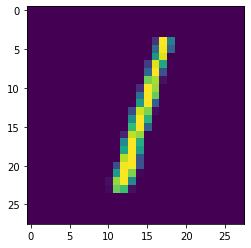

In [35]:
# Show normal data
plt.imshow(x_test[2])

In [36]:
# eps 0.3 - 22.02%
#Create FGSM Instance
attack2 = FastGradientMethod(estimator, eps=0.3)
#Create Adversarial Examples
examples = attack2.generate(x_test_reshaped,y_test)

prediction = model.predict(examples)

accuracy = np.sum(np.argmax(prediction, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on Adversarial Exmaples: {}%'.format(accuracy * 100))

Accuracy on Adversarial Exmaples: 22.02%


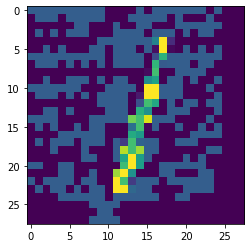

In [37]:
# Show Adversarial Examples
plt.imshow(examples[2].reshape(28,28))

In [38]:
#eps=0.3,num_random_init=3, batch_size = 16 - 11.68%
#Create FGSM Instance
attack2 = FastGradientMethod(estimator, eps=0.3,
                            num_random_init=3,batch_size = 16)
#Create Adversarial Examples
examples = attack2.generate(x_test_reshaped,y_test)

prediction = model.predict(examples)

accuracy = np.sum(np.argmax(prediction, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on Adversarial Exmaples: {}%'.format(accuracy * 100))

Accuracy on Adversarial Exmaples: 12.04%


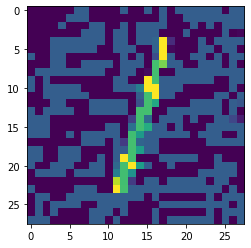

In [39]:
# Show Adversarial Examples
plt.imshow(examples[2].reshape(28,28))

In [46]:
# eps = 0.5 - 8.81%
#Create FGSM Instance
attack2 = FastGradientMethod(estimator, eps=0.5)
#Create Adversarial Examples
examples = attack2.generate(x_test_reshaped,y_test)

prediction = model.predict(examples)

accuracy = np.sum(np.argmax(prediction, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on Adversarial Exmaples: {}%'.format(accuracy * 100))

Accuracy on Adversarial Exmaples: 8.81%


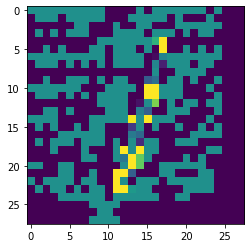

In [47]:
# Show Adversarial Examples
plt.imshow(examples[2].reshape(28,28))

In [48]:
#eps=0.5,num_random_init=3, batch_size = 16 - 1.41%
#Create FGSM Instance
attack2 = FastGradientMethod(estimator, eps=0.5,
                            num_random_init=3,batch_size = 16)
#Create Adversarial Examples
examples = attack2.generate(x_test_reshaped,y_test)

prediction = model.predict(examples)

accuracy = np.sum(np.argmax(prediction, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on Adversarial Exmaples: {}%'.format(accuracy * 100))

Accuracy on Adversarial Exmaples: 1.41%


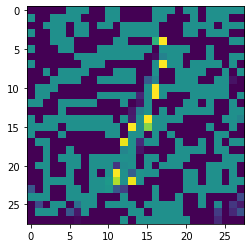

In [49]:
# Show Adversarial Examples
plt.imshow(examples[2].reshape(28,28))

In [50]:
# eps = 0.7 - 8.19%
#Create FGSM Instance
attack2 = FastGradientMethod(estimator, eps=0.7)
#Create Adversarial Examples
examples = attack2.generate(x_test_reshaped,y_test)

prediction = model.predict(examples)

accuracy = np.sum(np.argmax(prediction, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on Adversarial Exmaples: {}%'.format(accuracy * 100))

Accuracy on Adversarial Exmaples: 8.19%


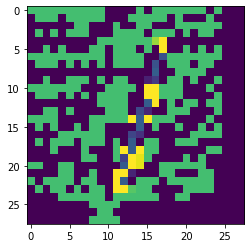

In [51]:
# Show Adversarial Examples
plt.imshow(examples[2].reshape(28,28))